
# Repetition Code (distance 5) — Custom Decoder Walkthrough & Stress Test

**Goal.** Build intuition for the distance‑5 repetition code under i.i.d. X errors on data qubits, verify our **custom time‑correlated decoder**, compare **custom loops vs Stim's built‑in multi‑shot sampler**, and then **stress test** logical vs uncorrected error rates.

**What we simulate (TL;DR):**
- Code: 1D repetition code of **distance d = 5** (five data qubits, four ancillas).
- Noise: i.i.d. **X_ERROR(p)** applied to **data** qubits each round.
- Measurement: per‑round ancilla parities via `MR`, then final data `M` for majority‑vote logical on \(|0_L\).
- Decoder: per round, decode **syndrome differences** via a **min‑weight prefix‑XOR** solution; accumulate a **Pauli frame** over time.
- Tools: **Stim** (circuits & sampling), **NumPy** (decoding), **Matplotlib** (plots).

> Short answers, minimal fluff. Run each cell top‑to‑bottom.


In [3]:

# --- Setup ---
import sys, time, math
import numpy as np
import matplotlib.pyplot as plt
import sys, os; sys.path.append(os.path.abspath(".."))
from src import distance_d_repetition_code, collect_stats, bits_to_str, decode_min_weight_from_syndrome
from IPython.display import display, SVG

np.set_printoptions(linewidth=120)



## 2) Distance‑5 circuit: build & inspect

We'll construct a **distance = 5** repetition‑code circuit with several rounds, visualize its **timeline diagram**, and then do a **single‑shot decode** while printing:
- round‑by‑round **syndromes**,
- **syndrome differences** (to suppress measurement noise),
- **per‑round min‑weight step** from our decoder,
- accumulated **Pauli frame**, and
- **raw vs corrected** majority‑vote outcomes.


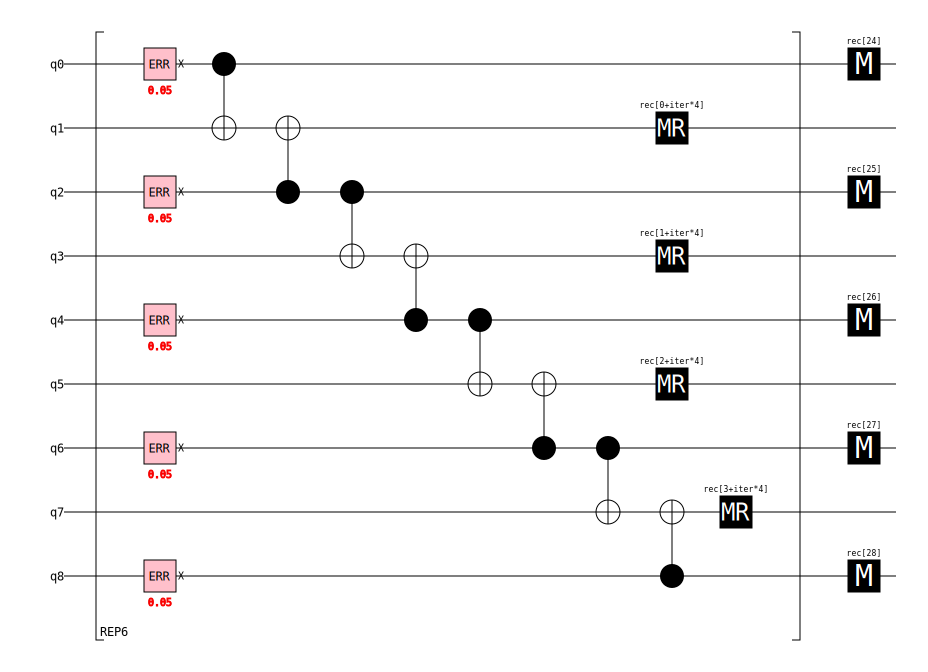

Syndromes per round:
  r=0: s = ____
  r=1: s = ____
  r=2: s = ____
  r=3: s = ____
  r=4: s = 11_1
  r=5: s = 11_1

Replaying the decoder (syndrome differencing + min-weight step):
  r=0: ds=____  step=_____  frame=_____
  r=1: ds=____  step=_____  frame=_____
  r=2: ds=____  step=_____  frame=_____
  r=3: ds=____  step=_____  frame=_____
  r=4: ds=11_1  step=_1__1  frame=_1__1
  r=5: ds=____  step=_____  frame=_1__1

Raw data:        _1__1   -> raw logical = 0
Corrected data:   _____   -> cor logical = 0


In [4]:

# --- Example parameters ---
d = 5         # distance (must be odd)
rounds = 6    # number of syndrome rounds
p = 0.05      # data X flip probability per round

# One single-shot run with rich introspection
out = distance_d_repetition_code(d, rounds, p)

# Visualize the timeline diagram
display(out["SVG"])

# Print arrays in a compact bit-string style
S = out["syndromes"].astype(np.uint8)      # shape (rounds, d-1)
data_final = out["data_final"]             # shape (d,)
corr_data  = out["corrected_data"]
frame      = out["frame"]

print("Syndromes per round:")
for r in range(rounds):
    print(f"  r={r}: s = {bits_to_str(S[r])}")

print("\nReplaying the decoder (syndrome differencing + min-weight step):")
prev = np.zeros(d-1, dtype=np.uint8)
pf   = np.zeros(d,   dtype=np.uint8)
for r in range(rounds):
    ds   = (S[r] ^ prev).astype(np.uint8)                    # de-noise via differencing
    step = decode_min_weight_from_syndrome(ds).astype(np.uint8)
    pf  ^= step
    prev = S[r]
    print(f"  r={r}: ds={bits_to_str(ds)}  step={bits_to_str(step)}  frame={bits_to_str(pf)}")

raw_L = 1 if int(data_final.sum()) > d//2 else 0
cor_L = 1 if int(corr_data.sum())  > d//2 else 0
print("\nRaw data:       ", bits_to_str(data_final), "  -> raw logical =", raw_L)
print("Corrected data:  ", bits_to_str(corr_data),  "  -> cor logical =", cor_L)



### Decoder intuition (super short)
For a length‑\(d\) chain with parity checks on neighboring pairs, a **syndrome vector** \(s\in\{0,1\}^{d-1}\) corresponds to data‑error patterns that **alternate** along the chain. The **prefix‑XOR** construction yields one consistent pattern \(e_0\); we pick the **min‑weight** of \(e_0\) or its complement. Across rounds, we **difference** syndromes before decoding to suppress measurement errors, and **accumulate** a running **Pauli frame**.


In [18]:

# Tiny demo: random syndrome differences -> decoder step
rng = np.random.default_rng(7)
ds = rng.integers(0, 2, size=d-1, dtype=np.uint8)
step = decode_min_weight_from_syndrome(ds).astype(np.uint8)
print("Random ds:", bits_to_str(ds), " -> step:", bits_to_str(step))


Random ds: 1_11  -> step: 1__1_



## 3_0) What we compare next
We compare **custom loops** (decoding a record at a time) vs **Stim’s built‑in multi‑shot sampling** (vectorized) using the *same* circuit and decoder:

- **Custom loops:** call `distance_d_repetition_code` per trial (clear but slower).
- **Built‑in shots:** one `compile_sampler().sample(trials)` + vectorized post‑processing (fast).

We'll check **rates match** (within sampling error) and show **runtime**.


In [20]:

def compare_loops_vs_builtin(d=5, rounds=100, p=0.02, trials=5000):
    t0 = time.perf_counter()
    stats_slow = collect_stats(d, rounds, p, trials=trials, fast=False)
    t1 = time.perf_counter()
    stats_fast = collect_stats(d, rounds, p, trials=trials, fast=True)
    t2 = time.perf_counter()

    # Print summary
    print("\n--- Comparison ---")
    print(f"Custom loops: raw={stats_slow['raw_rate']:.6f}, cor={stats_slow['corrected_rate']:.6f}, time={t1-t0:.3f}s")
    print(f"Built-in   : raw={stats_fast['raw_rate']:.6f}, cor={stats_fast['corrected_rate']:.6f}, time={t2-t1:.3f}s")

    # Sanity: rates should be close within ~a few sigma
    # (Very loose check; decrease tol or increase trials for tighter checks.)
    assert abs(stats_slow['raw_rate'] - stats_fast['raw_rate']) < 0.02 + 2/np.sqrt(trials), "Raw-rate mismatch"
    assert abs(stats_slow['corrected_rate'] - stats_fast['corrected_rate']) < 0.02 + 2/np.sqrt(trials), "Corrected-rate mismatch"

    return stats_slow, stats_fast, (t1-t0), (t2-t1)

# Run the comparison (adjust trials as needed)
_ = compare_loops_vs_builtin(d=5, rounds=100, p=0.02, trials=3000)


[distance=5, rounds=100, noise=0.02, trials=3000]
Raw logical error rate:       0.483333
Corrected logical error rate: 0.008000
Failures counted:             24/3000
[distance=5, rounds=100, noise=0.02, trials=3000]
Raw logical error rate:       0.488667
Corrected logical error rate: 0.005667
Failures counted:             17/3000

--- Comparison ---
Custom loops: raw=0.483333, cor=0.008000, time=10.276s
Built-in   : raw=0.488667, cor=0.005667, time=1.670s



## 4_0) Stress test plan
Now we **stick to built‑in shots** (fast path) and sweep noise \(p\) to compare:
- **Uncorrected (raw)** logical rate (majority vote on final data, no frame)
- **Corrected** logical rate (with our time‑correlated Pauli‑frame decoder)

We'll plot both vs \(p\) for fixed \(d=5\) and a chosen number of rounds.


In [22]:

# --- Sweep noise and plot raw vs corrected logical error rates ---
import pandas as pd

d = 5
rounds = 200
trials = 3000

ps = np.linspace(0.0, 0.20, 11)   # 0.00 ... 0.20
raw_rates = []
cor_rates = []

for p in ps:
    stats = collect_stats(d, rounds, float(p), trials=trials, fast=True)
    raw_rates.append(stats["raw_rate"])
    cor_rates.append(stats["corrected_rate"])

df = pd.DataFrame({
    "p": ps,
    "raw_rate": raw_rates,
    "corrected_rate": cor_rates,
})
df


[distance=5, rounds=200, noise=0.0, trials=3000]
Raw logical error rate:       0.000000
Corrected logical error rate: 0.000000
Failures counted:             0/3000
[distance=5, rounds=200, noise=0.02, trials=3000]
Raw logical error rate:       0.498000
Corrected logical error rate: 0.013000
Failures counted:             39/3000
[distance=5, rounds=200, noise=0.04, trials=3000]
Raw logical error rate:       0.508667
Corrected logical error rate: 0.100333
Failures counted:             301/3000
[distance=5, rounds=200, noise=0.06, trials=3000]
Raw logical error rate:       0.496333
Corrected logical error rate: 0.273333
Failures counted:             820/3000
[distance=5, rounds=200, noise=0.08, trials=3000]
Raw logical error rate:       0.504000
Corrected logical error rate: 0.426000
Failures counted:             1278/3000
[distance=5, rounds=200, noise=0.1, trials=3000]
Raw logical error rate:       0.518333
Corrected logical error rate: 0.494667
Failures counted:             1484/3000
[

,p,raw_rate,corrected_rate
0,0.00,0.000000,0.000000
1,0.02,0.498000,0.013000
2,0.04,0.508667,0.100333
3,0.06,0.496333,0.273333
4,0.08,0.504000,0.426000
5,0.10,0.518333,0.494667
6,0.12,0.503667,0.491000
7,0.14,0.490333,0.490333
8,0.16,0.498667,0.506000
9,0.18,0.499000,0.495000


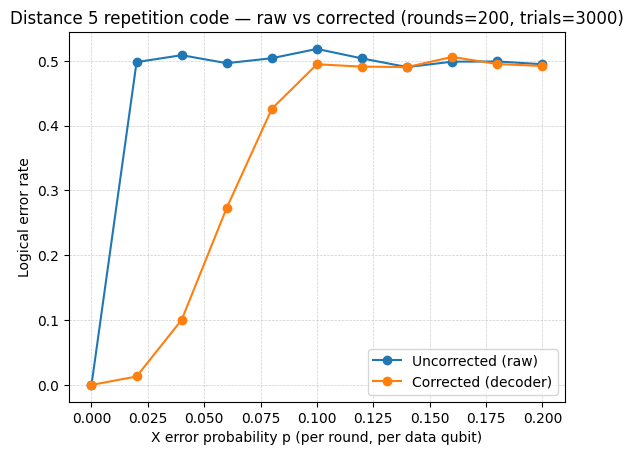

In [23]:

plt.figure()
plt.plot(df["p"], df["raw_rate"], marker="o", label="Uncorrected (raw)")
plt.plot(df["p"], df["corrected_rate"], marker="o", label="Corrected (decoder)")
plt.xlabel("X error probability p (per round, per data qubit)")
plt.ylabel("Logical error rate")
plt.title(f"Distance {d} repetition code — raw vs corrected (rounds={rounds}, trials={trials})")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()
plt.show()



### Takeaways (short)
- The **vectorized built‑in shots** path matches the **custom loop** results and is **much faster**.
- Our **time‑correlated decoder** significantly suppresses the logical error vs the uncorrected majority vote, especially at **small–moderate p** and **more rounds**.
- For deeper studies, sweep **distance/rounds**, add **measurement errors**, and compare to an **optimal MWPM** or other decoders.
